In [0]:
!pip install catboost

     |████████████████████████████████| 64.4MB 54kB/s 


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import catboost

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/data_titanic/train.csv')
data.head()
# data.shape

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
for i in data.columns:
  print(i)

PassengerId
Survived
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [0]:
test_data = pd.read_csv('drive/My Drive/Colab Notebooks/data_titanic/test.csv')
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [0]:
X = data.drop('Survived', axis=1)
y = data['Survived']

In [0]:
X.head()
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# **Обработка и очищение данных**

In [0]:
def num_sex(sex):
  if sex == 'male':
    return 1
  else:
    return 2

In [0]:
def data_preparation(raw_data):
  raw_data['Sex_num'] = raw_data['Sex'].apply(num_sex)
  # raw_data['Family'] = raw_data['SibSp'] + raw_data['Parch']
  raw_data_cat = pd.get_dummies(raw_data.Embarked)
  new_data = pd.concat([raw_data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_num']], raw_data_cat], axis=1)
  return new_data

In [0]:
def data_preparation_full(raw_data):
  if int(raw_data['Fare'].isnull().sum()) > 0:
    raw_data.Fare.fillna(raw_data.Fare.mean(), inplace=True)
  if int(raw_data['Cabin'].isnull().sum()) > 0:
    raw_data.Cabin.fillna('-42', inplace=True)
  if int(raw_data['Embarked'].isnull().sum()) > 0:
    raw_data.Embarked.fillna('-42', inplace=True)
  raw_data.Age.fillna(raw_data.Age.mean(), inplace=True)
  return raw_data

In [0]:
prepared_train_data = data_preparation_full(X.copy())
prepared_train_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,-42,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,-42,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,-42,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,-42,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,-42,S
889,890,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C


In [0]:
prepared_train_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [0]:
prepared_test_data = data_preparation_full(test_data.copy())
prepared_test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,-42,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,-42,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,-42,Q
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,-42,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,-42,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,-42,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,-42,S
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,-42,S


In [0]:
prepared_test_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [0]:
categorical_features_indices = np.where(prepared_train_data.dtypes == object)[0]

In [0]:
categorical_features_indices

array([ 2,  3,  7,  9, 10])

In [0]:
prepared_train_data.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# **Визуализация данных**

In [0]:
for_viz = prepared_train_data.copy()
for_viz['Survived'] = y

In [0]:
for_viz['Sex_num'] = for_viz['Sex'].apply(num_sex)

In [0]:
for_viz.drop(['PassengerId'], axis=1).describe()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_num
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838,1.352413
std,0.836071,13.002015,1.102743,0.806057,49.693429,0.486592,0.477990
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.000000
50%,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,1.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,2.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,2.000000


In [0]:
for_viz.drop(['PassengerId'], axis=1).corr()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_num
Pclass,1.000000,-0.331339,0.083081,0.018443,-0.549500,-0.338481,-0.131900
Age,-0.331339,1.000000,-0.232625,-0.179191,0.091566,-0.069809,-0.084153
SibSp,0.083081,-0.232625,1.000000,0.414838,0.159651,-0.035322,0.114631
Parch,0.018443,-0.179191,0.414838,1.000000,0.216225,0.081629,0.245489
Fare,-0.549500,0.091566,0.159651,0.216225,1.000000,0.257307,0.182333
Survived,-0.338481,-0.069809,-0.035322,0.081629,0.257307,1.000000,0.543351
Sex_num,-0.131900,-0.084153,0.114631,0.245489,0.182333,0.543351,1.000000


In [0]:
for_viz.drop(['PassengerId', 'Survived'], axis=1).corrwith(for_viz['Survived'])

Pclass    -0.338481
Age       -0.069809
SibSp     -0.035322
Parch      0.081629
Fare       0.257307
Sex_num    0.543351
dtype: float64

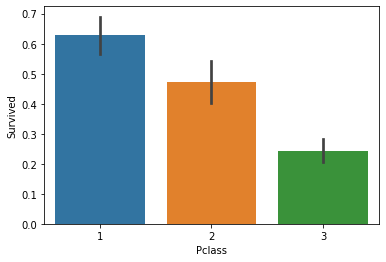

In [0]:
sns.barplot(x='Pclass', y='Survived', data=for_viz);

In [0]:
for_viz[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


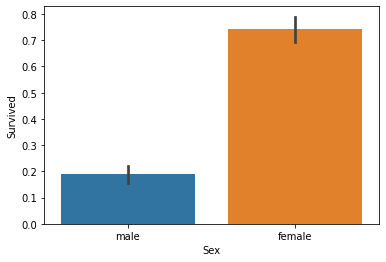

In [0]:
sns.barplot(x='Sex', y='Survived', data=for_viz);

In [0]:
for_viz[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


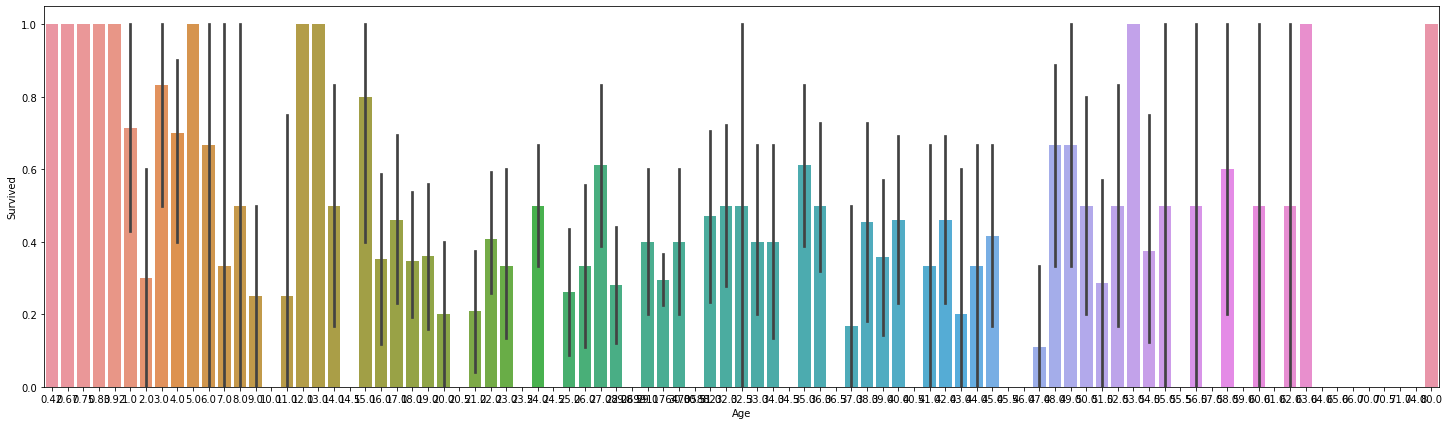

In [0]:
plt.figure(figsize=(25, 7))
sns.barplot(x='Age', y='Survived', data=for_viz);

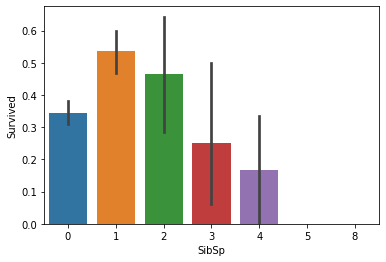

In [0]:
sns.barplot(x='SibSp', y='Survived', data=for_viz);

In [0]:
for_viz[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


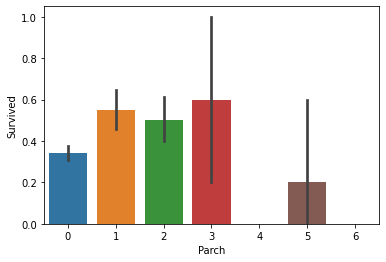

In [0]:
sns.barplot(x='Parch', y='Survived', data=for_viz);

In [0]:
for_viz[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


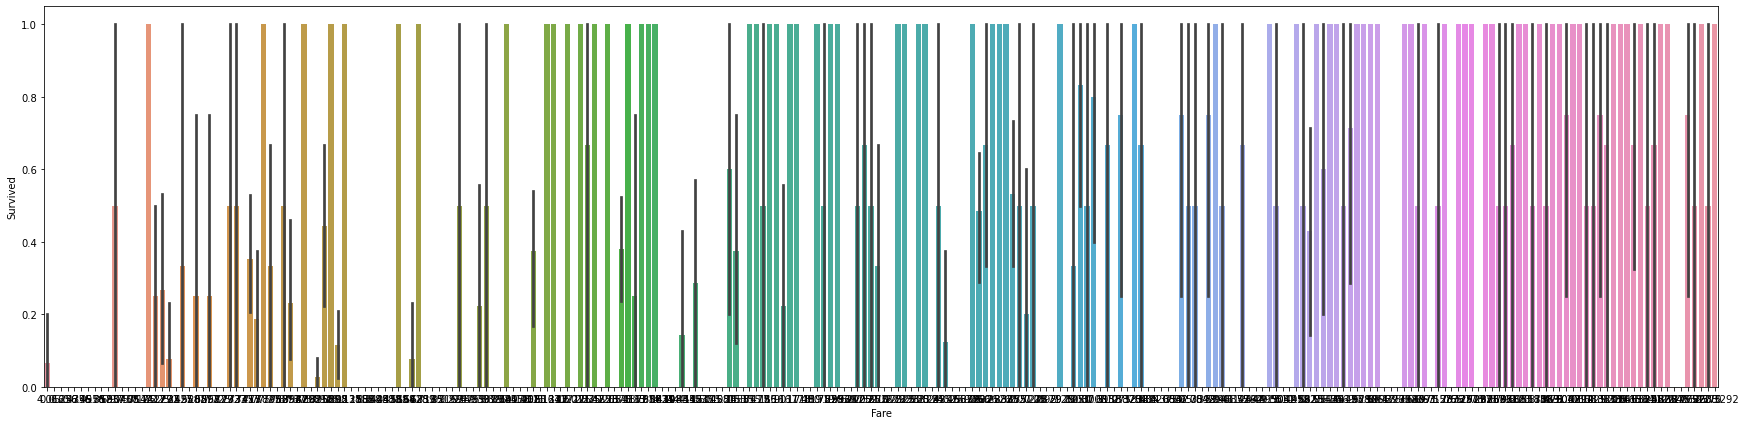

In [0]:
plt.figure(figsize=(30, 7))
sns.barplot(x='Fare', y='Survived', data=for_viz);

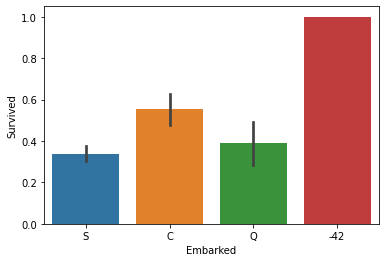

In [0]:
sns.barplot(x='Embarked', y='Survived', data=for_viz);

In [0]:
for_viz[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,-42,1.000000
1,C,0.553571
2,Q,0.389610
3,S,0.336957


# **Первая модель**

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [0]:
X_train, X_validation, y_train, y_validation = train_test_split(prepared_train_data, y, train_size=0.75, random_state=42)

# Catboost

In [0]:
model = catboost.CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [0]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    # logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = catboost.cv(
    catboost.Pool(prepared_train_data, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
answer = model.predict(X_validation)

In [0]:
accuracy_score(y_validation, model.predict(X_validation))

0.8340807174887892

In [0]:
roc_auc_score(y_validation, answer)

0.8147744423947677

In [0]:
for i, j in zip(prepared_train_data.columns, model.feature_importances_):
  print(i, j)

PassengerId 5.2648182001648935
Pclass 15.0786241826928
Name 0.0
Sex 38.237961934799046
Age 10.099562833269966
SibSp 2.4090801714366306
Parch 1.4713565230041743
Ticket 6.7158615128682175
Fare 6.433549479404665
Cabin 7.182246030459222
Embarked 7.106939131900393


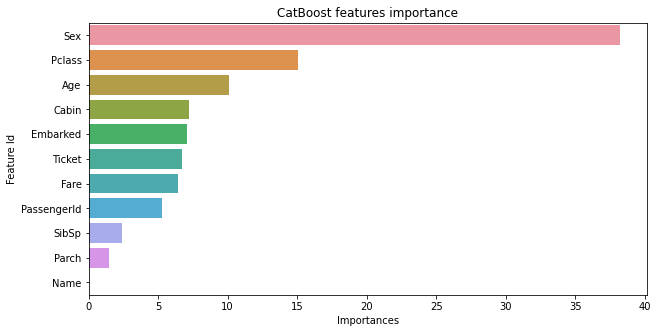

In [0]:
feature_importance_df = pd.DataFrame(model.get_feature_importance(prettified=True),
                                     columns=['Feature Id', 'Importances'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Importances', y='Feature Id', data=feature_importance_df)
plt.title('CatBoost features importance');

# RandomForest

In [0]:
prepared_train_data_rf = data_preparation(prepared_train_data.copy())
prepared_test_data_rf = data_preparation(prepared_test_data.copy())

In [0]:
X_train_rf, X_validation_rf, y_train_rf, y_validation_rf = train_test_split(prepared_train_data_rf, y, train_size=0.75, random_state=42)

In [0]:
model2 = RandomForestClassifier(random_state=42)

In [0]:
model2.fit(X_train_rf, y_train_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
answer2 = model2.predict(X_validation_rf)

In [0]:
accuracy_score(y_validation_rf, answer2)

0.7802690582959642

In [0]:
roc_auc_score(y_validation_rf, answer2)

0.7737715914807982

In [0]:
for i, j in zip(prepared_train_data_rf.columns, model2.feature_importances_):
  print(i, j)

Pclass 0.07916886338991164
Age 0.2531961654955593
SibSp 0.0507361209258077
Parch 0.03917180075096612
Fare 0.27046835424616517
Sex_num 0.26780053111009816
-42 0.00016774156836500548
C 0.015162374588752248
Q 0.007518680900067085
S 0.01660936702430754


# LogisticRegression

In [0]:
model3 = LogisticRegression(random_state=42)

In [0]:
model3.fit(X_train_rf, y_train_rf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
answer3 = model3.predict(X_validation_rf)

In [0]:
accuracy_score(y_validation_rf,answer3)

0.8026905829596412

In [0]:
roc_auc_score(y_validation_rf, answer3)

0.7905416736542009

In [0]:
for i, j in zip(prepared_train_data_rf.columns, np.abs(model3.coef_)[0]): # feature importance
  print(i, j)

Pclass 0.9522940711384973
Age 0.03514363724052909
SibSp 0.2615605148173687
Parch 0.1121561120647603
Fare 0.003148974731253807
Sex_num 2.528414965863245
-42 0.08712030494642588
C 0.0098075042491834
Q 0.0279782366394343
S 0.4253648539487078


# Feature selection

In [0]:
selected_features = ['Sex', 'Pclass', 'Age', 'Cabin', 'Embarked', 'SibSp', 'Parch', 'Fare', 'Ticket']
cat_features = ['Sex', 'Pclass', 'Cabin', 'Embarked', 'Ticket']

In [0]:
prepared_train_data[selected_features]
X_train[selected_features]

,Sex,Pclass,Age,Cabin,Embarked,SibSp,Parch,Fare,Ticket
298,male,1,29.699118,C106,S,0,0,30.5000,19988
884,male,3,25.000000,-42,S,0,0,7.0500,SOTON/OQ 392076
247,female,2,24.000000,-42,S,0,2,14.5000,250649
478,male,3,22.000000,-42,S,0,0,7.5208,350060
305,male,1,0.920000,C22 C26,S,1,2,151.5500,113781
...,...,...,...,...,...,...,...,...,...
106,female,3,21.000000,-42,S,0,0,7.6500,343120
270,male,1,29.699118,-42,S,0,0,31.0000,113798
860,male,3,41.000000,-42,S,2,0,14.1083,350026
435,female,1,14.000000,B96 B98,S,1,2,120.0000,113760


# **Grid Search**

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

In [63]:
%%time
model_params = {'cat_features': cat_features,
                'custom_loss':['Accuracy'],
                # 'loss_function': 'Accuracy',
                'verbose': False}

model4 = catboost.CatBoostClassifier(**model_params)

grid_params = {'depth': [13, 14, 15],
               'iterations': range(30, 42, 1),
               'learning_rate': np.linspace(0.4, 0.1, 40)}

grid_res = model4.grid_search(grid_params, X=X_train[selected_features], y=y_train, cv=3, shuffle=True, verbose=False)

CPU times: user 1h 18min 53s, sys: 2min 31s, total: 1h 21min 25s
Wall time: 41min 57s


In [64]:
grid_res['params']

{'depth': 13, 'iterations': 30, 'learning_rate': 0.1923076923076923}

In [0]:
best_model = catboost.CatBoostClassifier(verbose=False,
                           custom_loss='Accuracy',
                           cat_features=cat_features,
                           depth=grid_res['params']['depth'],
                           iterations=grid_res['params']['iterations'],
                           learning_rate=grid_res['params']['learning_rate'])

In [0]:
best_model.fit(X_train[selected_features], y_train)
y_pred_old = best_model.predict(X_validation[selected_features])

Scores:
Accuracy - 0.8116591928251121
Precision - 0.7901234567901234
Recall - 0.7191011235955056
F1 - 0.7529411764705881
ROC_AUC - 0.7961177259768573


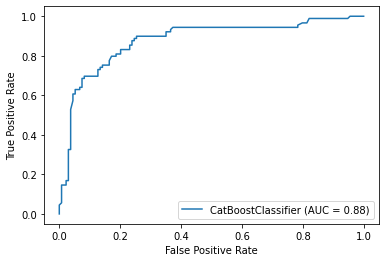

In [67]:
acc = accuracy_score(y_validation, y_pred_old)
pre = precision_score(y_validation, y_pred_old)
rec = recall_score(y_validation, y_pred_old)
f1 = f1_score(y_validation, y_pred_old)
ra = roc_auc_score(y_validation, y_pred_old)
print("Scores:\nAccuracy - {}\nPrecision - {}\nRecall - {}\nF1 - {}\nROC_AUC - {}".format(acc, pre, rec, f1, ra))
plot_roc_curve(best_model, X_validation[selected_features], y_validation);

In [0]:
best_model.fit(prepared_train_data[selected_features], y)
y_pred = best_model.predict(prepared_test_data[selected_features])

In [0]:
sub = pd.DataFrame({'PassengerId':test_data['PassengerId'], 'Survived':y_pred.astype(int)})
sub.to_csv('titanic_sub4.csv', index=False)

In [70]:
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
